In [3]:
import tensorflow as tf
import numpy as np

print("✅ TensorFlow imported successfully")
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("Available devices:", tf.config.list_physical_devices())


✅ TensorFlow imported successfully
TensorFlow version: 2.15.0
NumPy version: 1.26.4
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [5]:
# Cell 1
import os
import numpy as np
import joblib as jlb
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

print("TF:", tf.__version__)


TF: 2.15.0


In [6]:
# Cell 2 - load saved arrays
X_train = jlb.load("X_train.jlb")
X_test  = jlb.load("X_test.jlb")
y_train = jlb.load("y_train.jlb")
y_test  = jlb.load("y_test.jlb")

print("Shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

# Ensure correct dtypes and normalization
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
if X_train.max() > 1.0:
    X_train /= 255.0
    X_test  /= 255.0

# Ensure masks shape is (N,H,W) integer labels
if y_train.ndim == 4 and y_train.shape[-1] == 1:
    y_train = y_train[...,0]
if y_test.ndim == 4 and y_test.shape[-1] == 1:
    y_test = y_test[...,0]
y_train = y_train.astype(np.int32)
y_test  = y_test.astype(np.int32)

print("After normalize & fix shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)


Shapes:
X_train: (1008, 256, 256, 3)
X_test : (252, 256, 256, 3)
y_train: (1008, 256, 256)
y_test : (252, 256, 256)
After normalize & fix shapes:
X_train: (1008, 256, 256, 3) y_train: (1008, 256, 256)


In [7]:
# Cell 3 — Build U-Net model
from tensorflow.keras import layers, models, backend as K

def unet_model(input_size=(256, 256, 3), num_classes=2):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    # Output layer (num_classes = 2)
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
model = unet_model(input_size=(256, 256, 3), num_classes=2)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [8]:
# Fix mask values (convert 255 -> 1)
y_train = np.where(y_train > 0, 1, 0).astype(np.uint8)
y_test  = np.where(y_test > 0, 1, 0).astype(np.uint8)

print("Unique values in y_train:", np.unique(y_train))


Unique values in y_train: [0 1]


In [11]:
# Cell 4 — Train the U-Net
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks to save best model and stop early if no improvement
checkpoint = ModelCheckpoint("unet_best_model.keras", monitor="val_loss", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=8,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

Epoch 1/20
126/126 [==============================] - ETA: 0s - loss: 0.2140 - accuracy: 0.9279 
Epoch 1: val_loss improved from inf to 0.21223, saving model to unet_best_model.keras
126/126 [==============================] - 2898s 23s/step - loss: 0.2140 - accuracy: 0.9279 - val_loss: 0.2122 - val_accuracy: 0.9258
Epoch 2/20
126/126 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.9285 
Epoch 2: val_loss did not improve from 0.21223
126/126 [==============================] - 2728s 22s/step - loss: 0.2115 - accuracy: 0.9285 - val_loss: 0.2301 - val_accuracy: 0.9237
Epoch 3/20
126/126 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9292 
Epoch 3: val_loss did not improve from 0.21223
126/126 [==============================] - 2826s 22s/step - loss: 0.2063 - accuracy: 0.9292 - val_loss: 0.2212 - val_accuracy: 0.9171
Epoch 4/20
126/126 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.9291 
Epoch 4: val_loss did not impr

KeyboardInterrupt: 

In [10]:
from tensorflow.keras.models import load_model

# Load the saved model checkpoint
model = load_model("unet_best_model.keras")

print("✅ Model loaded successfully. Ready to continue training!")

✅ Model loaded successfully. Ready to continue training!


In [12]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load trained model
model = load_model("unet_best_model.keras")

1/1 [==============================] - 0s 375ms/step


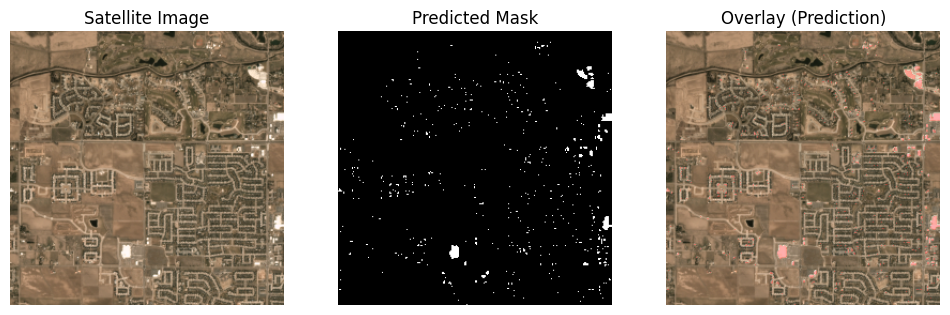

🏡 Predicted: **Residential Area**


In [26]:

import joblib

# --- Load dataset ---
X_test = joblib.load(r"C:\Users\HP\Desktop\Reality_AI\spacenet\X_test.jlb")
y_test = joblib.load(r"C:\Users\HP\Desktop\Reality_AI\spacenet\y_test.jlb")

# --- Pick one test image ---
index = 0
test_image = X_test[index]
true_mask = y_test[index]

# --- Normalize if needed ---
if test_image.max() > 1:
    test_image = test_image / 255.0

# --- Predict mask ---
image_input = np.expand_dims(test_image, axis=0)
pred_mask = model.predict(image_input)[0]

# Convert to single channel
if pred_mask.shape[-1] > 1:
    pred_mask = np.argmax(pred_mask, axis=-1)
else:
    pred_mask = pred_mask.squeeze()

pred_mask = (pred_mask > 0.5).astype(np.uint8)

# --- Prepare image for display ---
img_display = (test_image * 255.0 / test_image.max()).astype(np.uint8)

# --- Create overlay (red for predicted area) ---
overlay = img_display.copy()
red, green, blue = overlay[..., 0], overlay[..., 1], overlay[..., 2]

red[pred_mask == 1] = 255   # Make red channel bright
green[pred_mask == 1] = 0   # Remove green
blue[pred_mask == 1] = 0    # Remove blue

overlay = np.stack([red, green, blue], axis=-1)
blended = cv2.addWeighted(img_display, 0.7, overlay, 0.3, 0)

# --- Display results ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_display)
plt.title("Satellite Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(blended)
plt.title("Overlay (Prediction)")
plt.axis("off")

plt.show()

# --- Optional classification ---
area_ratio = pred_mask.mean()
if area_ratio > 0.5:
    print("🏙️ Predicted: **Commercial Area**")
else:
    print("🏡 Predicted: **Residential Area**")


In [23]:
print("Image shape:", test_image.shape)
print("Min pixel:", test_image.min())
print("Max pixel:", test_image.max())
print("Mean pixel:", test_image.mean())


Image shape: (256, 256, 3)
Min pixel: 0.0001845444
Max pixel: 0.003921569
Mean pixel: 0.0016630482


1/1 [==============================] - 0s 349ms/step


c:\Users\HP\Desktop\Reality_AI\unet_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127969 (\N{HOUSE WITH GARDEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


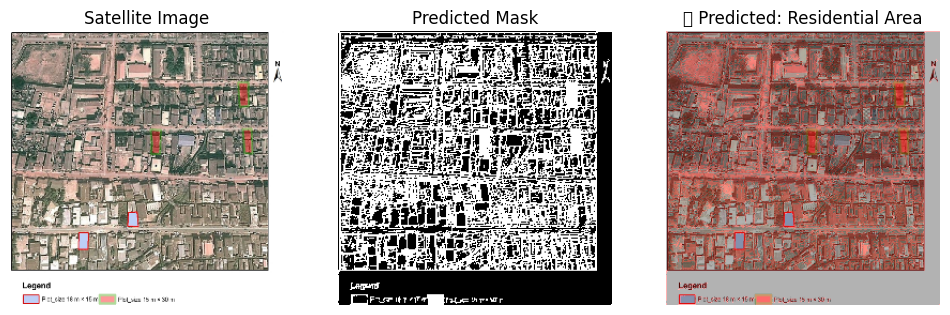

✅ 🏡 Predicted: Residential Area


In [31]:


# --- Path to uploaded image ---
img_path = r"C:\Users\HP\Desktop\Reality_AI\spacenet\image.png"

# --- Load and preprocess image ---
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"❌ Could not find: {img_path}")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, (256, 256))
img_input = img_resized / 255.0
img_input = np.expand_dims(img_input, axis=0)  # (1, 256, 256, 3)

# --- Predict mask ---
pred_mask = model.predict(img_input)[0]

# Ensure mask is 2D
pred_mask = np.squeeze(pred_mask)
if pred_mask.ndim == 3:
    pred_mask = pred_mask[..., 0]
pred_mask = (pred_mask > 0.5).astype(np.uint8)

# --- Create overlay ---
overlay = img_resized.copy()
red_layer = np.zeros_like(img_resized)

# Assign red pixels where mask == 1
red_layer[:, :, 0] = pred_mask * 255   # Red channel
red_layer[:, :, 1] = 0                 # Green
red_layer[:, :, 2] = 0                 # Blue

# Blend original and red overlay
blended = cv2.addWeighted(img_resized, 0.7, red_layer, 0.3, 0)

# --- Classification based on mask coverage ---
pred_ratio = np.mean(pred_mask)
if pred_ratio > 0.05:
    label = "🏡 Predicted: Residential Area"
else:
    label = "🏢 Predicted: Commercial / Non-Residential Area"

# --- Display results ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(img_resized); plt.title("Satellite Image"); plt.axis("off")
plt.subplot(1, 3, 2); plt.imshow(pred_mask, cmap='gray'); plt.title("Predicted Mask"); plt.axis("off")
plt.subplot(1, 3, 3); plt.imshow(blended); plt.title(label); plt.axis("off")
plt.show()

print("✅", label)
